# Topic 1: AWS Data Access

In [4]:
import matplotlib.pyplot as plt
import requests 
import boto3
import rasterio as rio
from rasterio.plot import show
from botocore.config import Config

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4300020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overviews levels: [2, 4, 8, 16]
<class 'rasterio.io.DatasetReader'>


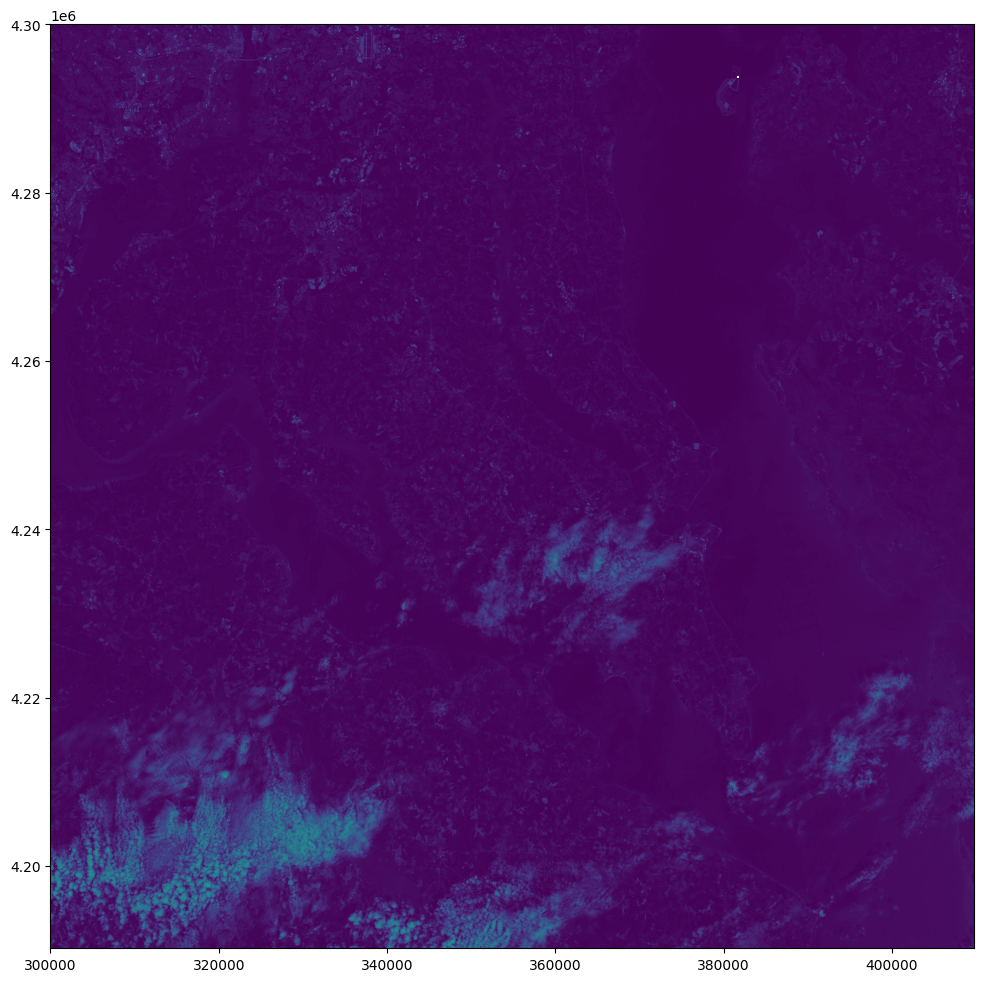

In [6]:
fo_url = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/S/UH/2020/7/S2A_18SUH_20200729_0_L2A/B04.tif'

with rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',    # https://rasterio.readthedocs.io/en/latest/topics/configuration.html
             AWS_NO_SIGN_REQUEST='YES',
             GDAL_HTTP_UNSAFESSL='YES',
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif'):
    with rio.open(fo_url) as src:
        print(src.profile)
        print(f'Overviews levels: {src.overviews(1)}')
        print(type(src))
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        show(src)

# Topic 2: Cloud Optimized Data

In [ ]:
import matplotlib.pyplot as plt
import os
import requests
import boto3
import rasterio as rio                    # https://rasterio.readthedocs.io/en/latest/
from rasterio.plot import show
from rasterio.session import AWSSession
import rioxarray                          # https://corteva.github.io/rioxarray/stable/index.html
import xarray as xr
import pandas
import geopandas
import pyproj
from pyproj import Proj
from shapely.ops import transform
#import geoviews as gv
#from cartopy import crs
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
#gv.extension('bokeh', 'matplotlib')

In [ ]:
requests.packages.urllib3.disable_warnings()

def get_temp_creds():
    temp_creds_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
    return requests.get(temp_creds_url, verify=False).json()

temp_creds_req = get_temp_creds()
#temp_creds_req

session = boto3.Session(aws_access_key_id=temp_creds_req['accessKeyId'], 
                        aws_secret_access_key=temp_creds_req['secretAccessKey'],
                        aws_session_token=temp_creds_req['sessionToken'],
                        region_name='us-west-2')

rio_env = rio.Env(AWSSession(session),
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
                  VSI_CACHE=True,
                  region_name='us-west-2',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

In [ ]:
foa_url = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TGF.2020274T174141.v2.0/HLS.S30.T13TGF.2020274T174141.v2.0.B04.tif"

# Disable SSL verification for rasterio
with rio.Env(SSL_CERTFILE=None):
    with rio.open(foa_url) as src:
        hls_ov_levels = src.overviews(1)

# Enable SSL verification for rioxarray
xr.set_options(verify=False)

with rioxarray.open_rasterio(foa_url, masked=True, overview_level=1, chunks=True) as src:    # https://nbviewer.jupyter.org/gist/rsignell-usgs/f4dd62ad1274c5b5ed69e5a6b81c1295 & http://rasterio.readthedocs.io/en/latest/topics/resampling.html
    print(src)
    
src.hvplot.image(x='x', y='y', width=800, height=600)

with rioxarray.open_rasterio(foa_url, masked=True, overview_level=3, chunks=True) as src:
    print(src)

src.hvplot.image(x = 'x', y = 'y', width=800, height=600)

# Topic 3: Data Discovery: STAC & CMR-STAC API

import requests
from pystac_client import Client       # https://pystac-client.readthedocs.io/en/latest/index.html  
from collections import defaultdict
import json
import geopandas
import os
import certifi

#os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

requests.packages.urllib3.disable_warnings()  # Disable SSL warnings
requests.Session().verify = False

In [ ]:
stac_url = 'https://cmr.earthdata.nasa.gov/stac'
provider_cat = requests.get(stac_url, verify=False)

providers = [p['title'] for p in provider_cat.json()['links'] if 'child' in p['rel']]
providers

In [ ]:
provider = 'LPCLOUD'
provider_url = f'{stac_url}/{provider}'
provider_url

cat = requests.get(provider_url, verify=False)
cat.json()

In [ ]:
cols = [{l['href'].split('/')[-1]: l['href']} for l in cat.json() ['links'] if 'child' in l['rel']]
for c in cols:
    print(c)

try:
    print(f"Requesting page:")
    while nxt_pg := [l for l in cat.json()['links'] if 'next' in l['rel']][0]:
        print(f"{nxt_pg['href'].split('=')[-1]}...", end = ' ')
        cat = requests.get(nxt_pg['href'], verify=False)
        cols.extend([{l['href'].split('/')[-1]: l['href']} for l in cat.json()['links']if 'child' in l['rel']])
except:
    print('No additional pages')

In [ ]:
print(f'LPCLOUD has {len(cols)} Collections')

for c in cols:
    print(c)

In [ ]:
collection = 'HLSL30.v2.0'
collection_link = list(filter(lambda c: collection == list(c.keys())[0], cols))[0]
collection_link
requests.get(collection_link[collection], verify=False).json()

In [ ]:

field = geopandas.read_file('Field_Boundary.geojson')
field

fieldShape = field['geometry'][0]
fieldShape

#base = gv.tile_sources.EsriImagery.opts(width=650, height=500)
#farmField = gv.Polygons(fieldShape).opts(line_color='yellow', line_width=10, color=None)
#base * farmField

roi = json.loads(field.to_json())['features'][0]['geometry']
roi

#date_range = "2021-05-01T00:00:00Z/2021-08-30T23:59:59Z"    # closed interval
#date_range = "2021-05-01T00:00:00Z/.."                      # open interval - does not currently work with the CMR-STAC API
date_range = "2021-05/2021-08"

collections = ['HLSL30.v2.0', 'HLSS30.v2.0']
collections

print("\n")

item_collection = []
for collection in collections:
    collection_link = list(filter(lambda c: collection == list(c.keys())[0], cols))[0][collection]
    print(collection_link)
    collection_response = requests.get(collection_link, verify=False)
    collection_json = collection_response.json()
    print(collection_json)
    item_collection.extend(collection_json['features'])

filtered_items = []
for item in item_collection:
    item_geom = item['geometry']
    item_datetime = item['properties']['datetime']
    if geopandas.GeoSeries(item_geom).intersects(roi) and item_datetime.startswith('2021-05'):
        filtered_items.append(item)

print(f'Total matched items: {len(filtered_items)}')

for item in filtered_items[:5]:
    print(item)

first_item_dict = filtered_items[0]
print(first_item_dict)

cloudcover = 25

s30_bands = ['B8A', 'B04', 'B02', 'Fmask']    # S30 bands for EVI calculation and quality filtering -> NIR, RED, BLUE, Quality 
l30_bands = ['B05', 'B04', 'B02', 'Fmask']    # L30 bands for EVI calculation and quality filtering -> NIR, RED, BLUE, Quality 